In [69]:
# !pip install numpy
# !pip install scipy
# !pip install pandas
# !pip install matplotlib

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy import constants as const

### Предобработка

In [71]:
data = pd.read_csv(r"data_main.csv")
constant_background = 0.6798
data.N -= constant_background
data.head()
Ierr = 0.02

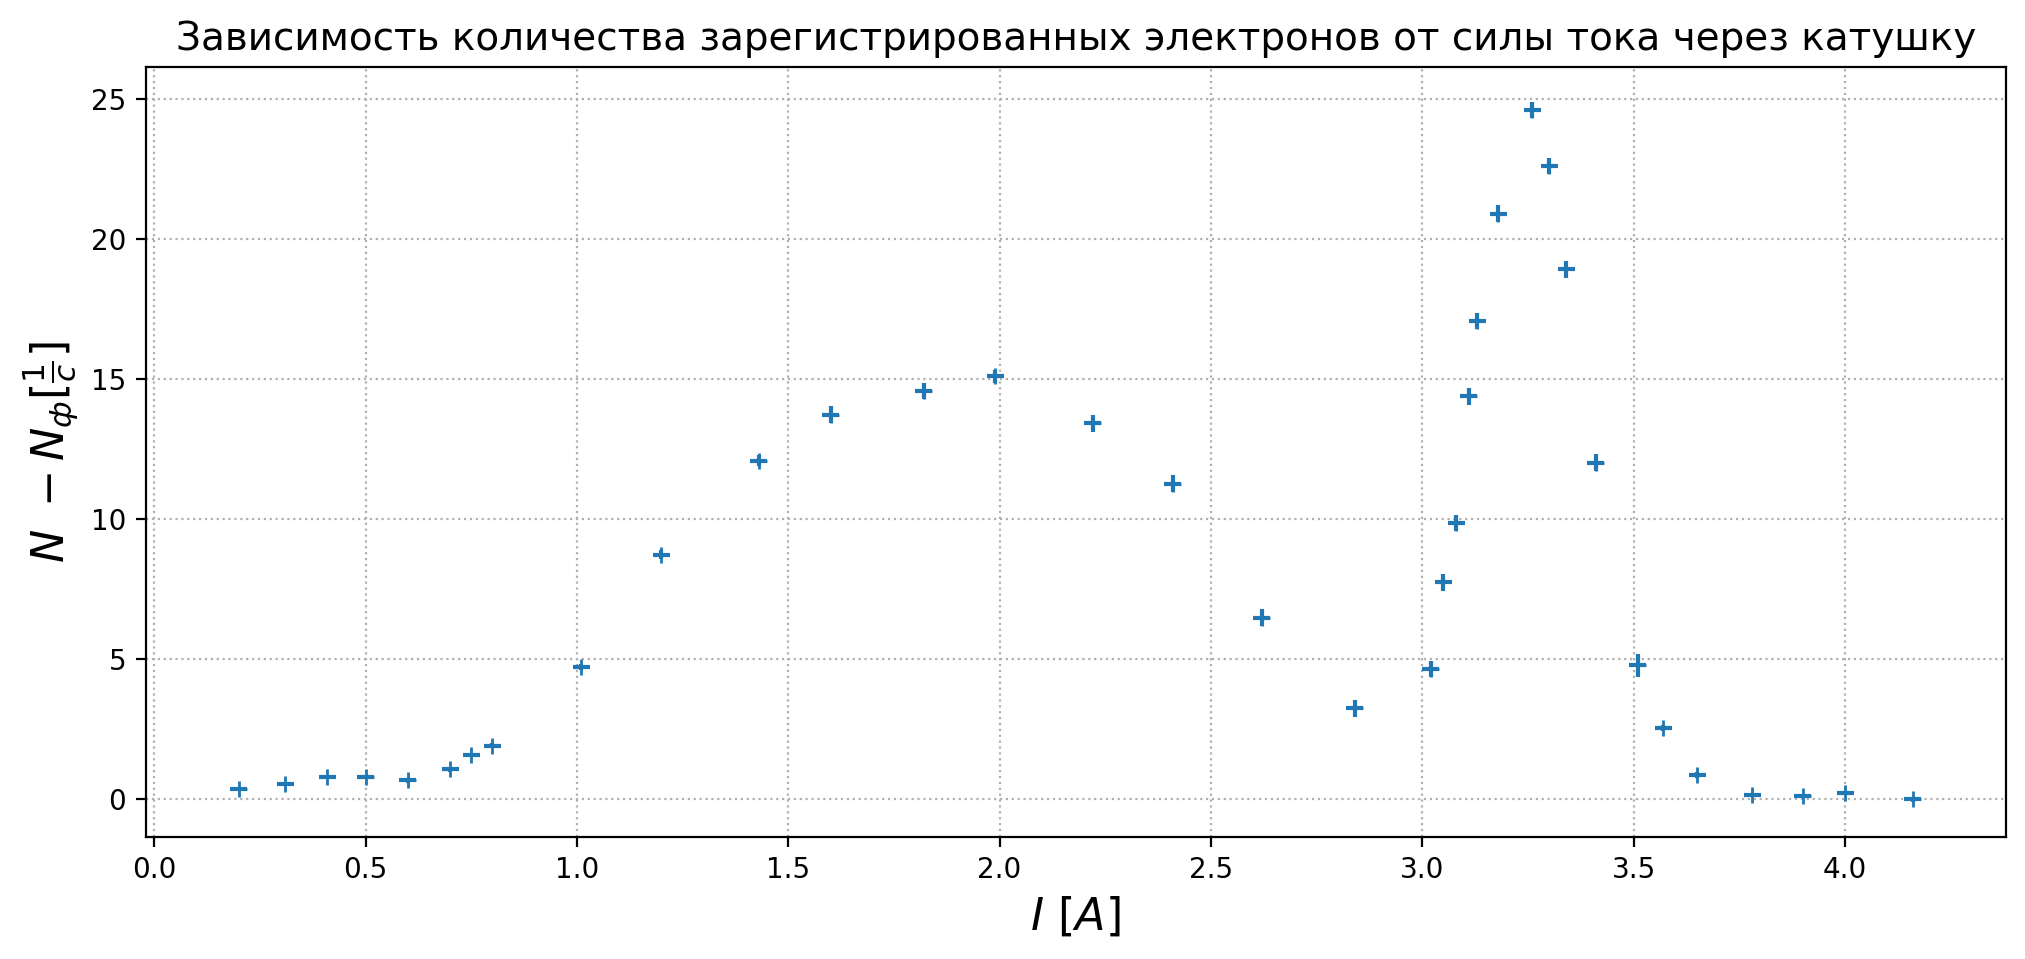

In [72]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.errorbar(data.Current, data.N, data.sigma, fmt = '+', xerr = [Ierr for _ in data.Current])
plt.grid(ls = ':')
plt.xlabel("$I \ [A]$", fontsize = 16)
plt.ylabel(r"$N \ - N_{ф} [\frac{1}{c}]$", fontsize = 16)
plt.title("Зависимость количества зарегистрированных электронов от силы тока через катушку",
          fontsize = 14);

### Калибровка спектрометра

Импульс прилетающих в камеру электронов линейно зависит от силы тока: $p_{e} = k I$. Коэффициент $k$ найдём из условия что конверсионные электроны имеют энергию $634 кЭВ$.

Для интерполяции полученной зависимости будем использовать данные полученные при регистрации неконверсионных электронов. Методом наименьших квадратов найдём максимальную энергию электронов в формуле:
$$
N(p) = p^{2} \cdot (E_{e} - E)^{2}
$$

Интерполяцию буду проводить в диапазоне $J \in [0, 2.8] \cup [3.5, 4.5]$

In [73]:
conversion_current = data.Current[np.argmax(data.N)] #сила тока при котрой улавливаются электроны конверсии
k = 634 / (const.c * conversion_current)
p = k * data.Current
energy = np.sqrt(np.power(p * const.c, 2) + np.power(const.electron_mass, 2) * np.power(const.c, 4))
p_line = np.linspace(np.min(p), np.max(p) / 2, 1000)
energy_line = np.linspace(50, 710, 1000)
no_conv_area = (data.Current < 2.5)

polynom_fit = np.poly1d(np.polyfit(energy, data.N, 30))

/tmp/ipykernel_95747/3179228681.py:9: RankWarning: Polyfit may be poorly conditioned
  polynom_fit = np.poly1d(np.polyfit(energy, data.N, 30))


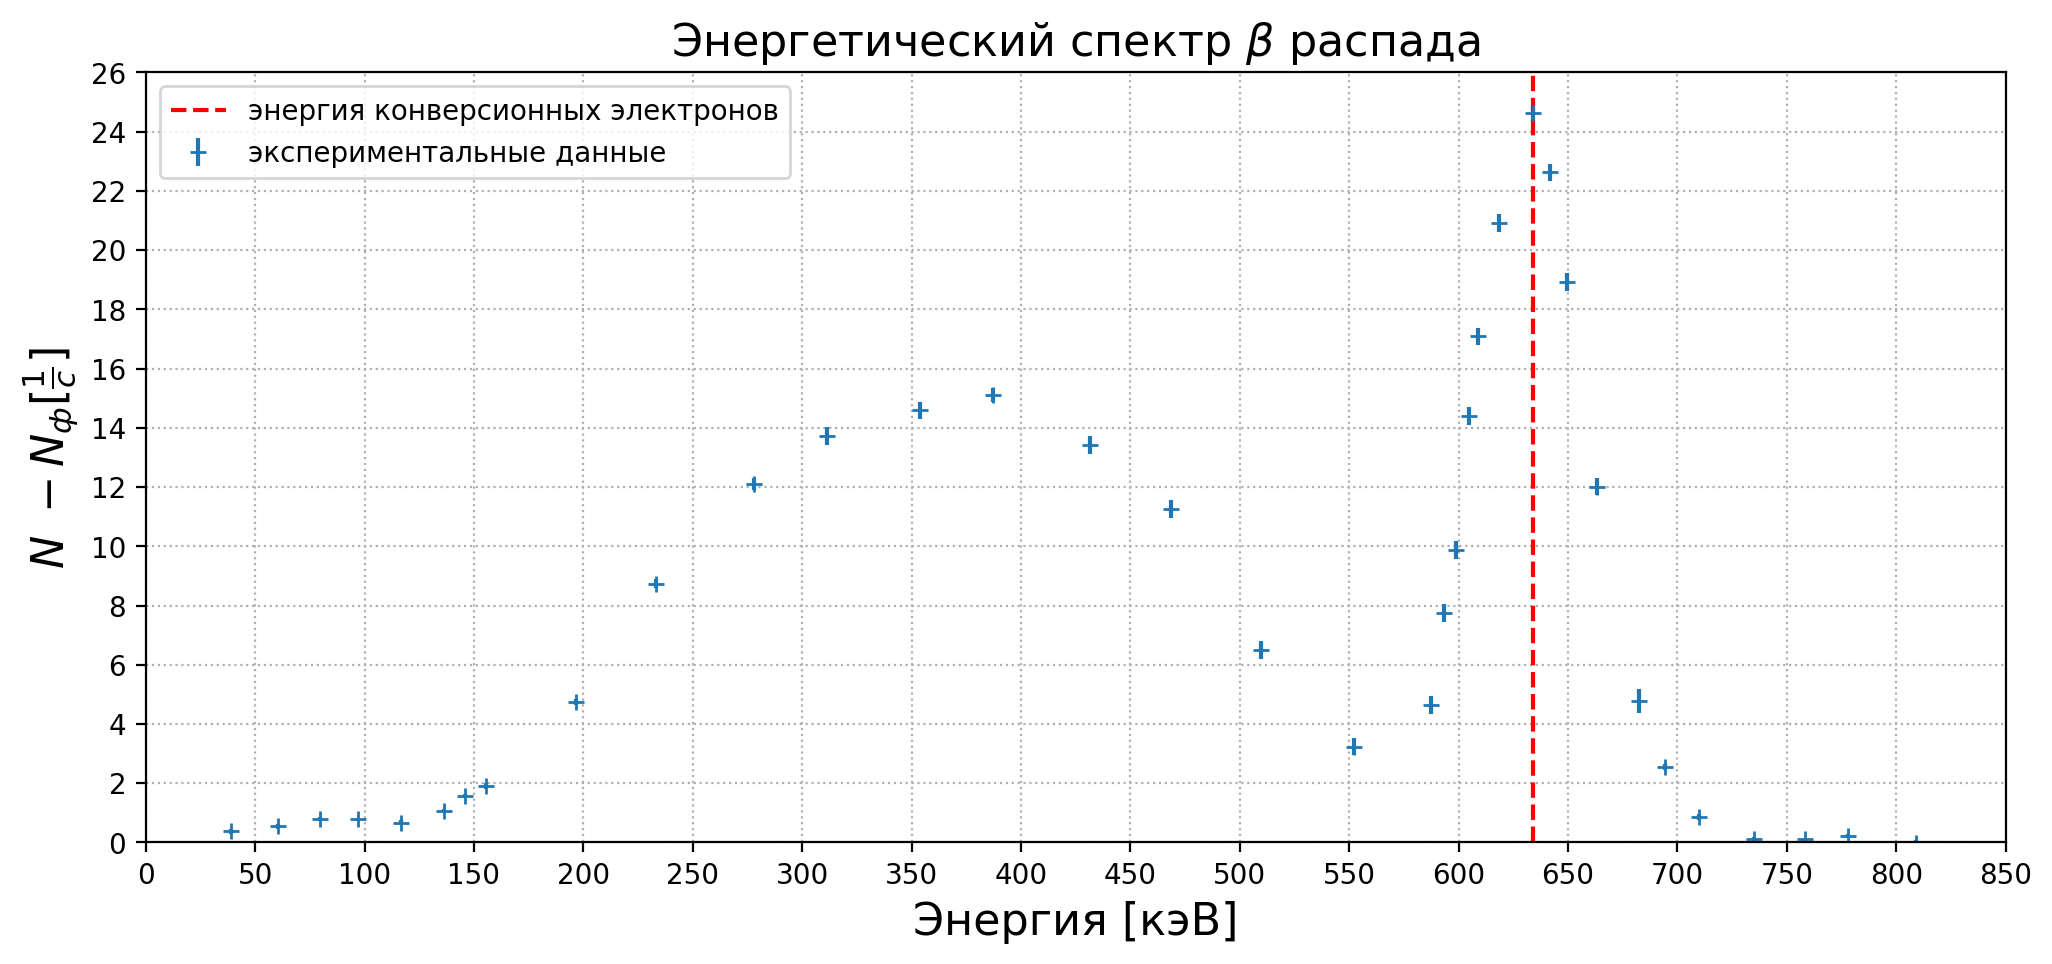

In [74]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.errorbar(energy, 
            data.N,
            data.sigma,
            fmt = '+',
            label = 'экспериментальные данные')
plt.axvline(634, linestyle = '--', color = 'red', label = 'энергия конверсионных электронов')
plt.xlabel("Энергия [кэВ]", fontsize = 16)
plt.ylabel(r"$N \ - N_{ф} [\frac{1}{c}]$", fontsize = 16)
plt.title(r"Энергетический спектр $\beta$ распада", fontsize = 16)
plt.grid(ls = ':')
plt.xticks(np.arange(0, 900 + 50, 50))
plt.yticks(np.arange(0, 27, 2))
plt.xlim(0, 850)
plt.ylim(0, 26)
plt.legend();

In [143]:
no_conv_area = (energy < 550) * (energy > 200)
fermi = np.sqrt(np.abs(data.N)) / np.power(p, 1.5)
MNK = linregress(energy[no_conv_area], fermi[no_conv_area])
A = np.vstack([energy[no_conv_area], np.ones(np.sum(no_conv_area))]).T
m, c = np.linalg.lstsq(A, fermi[no_conv_area], rcond=None)[0]
x_line = np.linspace(0, 1500, 1000)

Text(0.5, 1.0, 'График Ферми - Кюри')

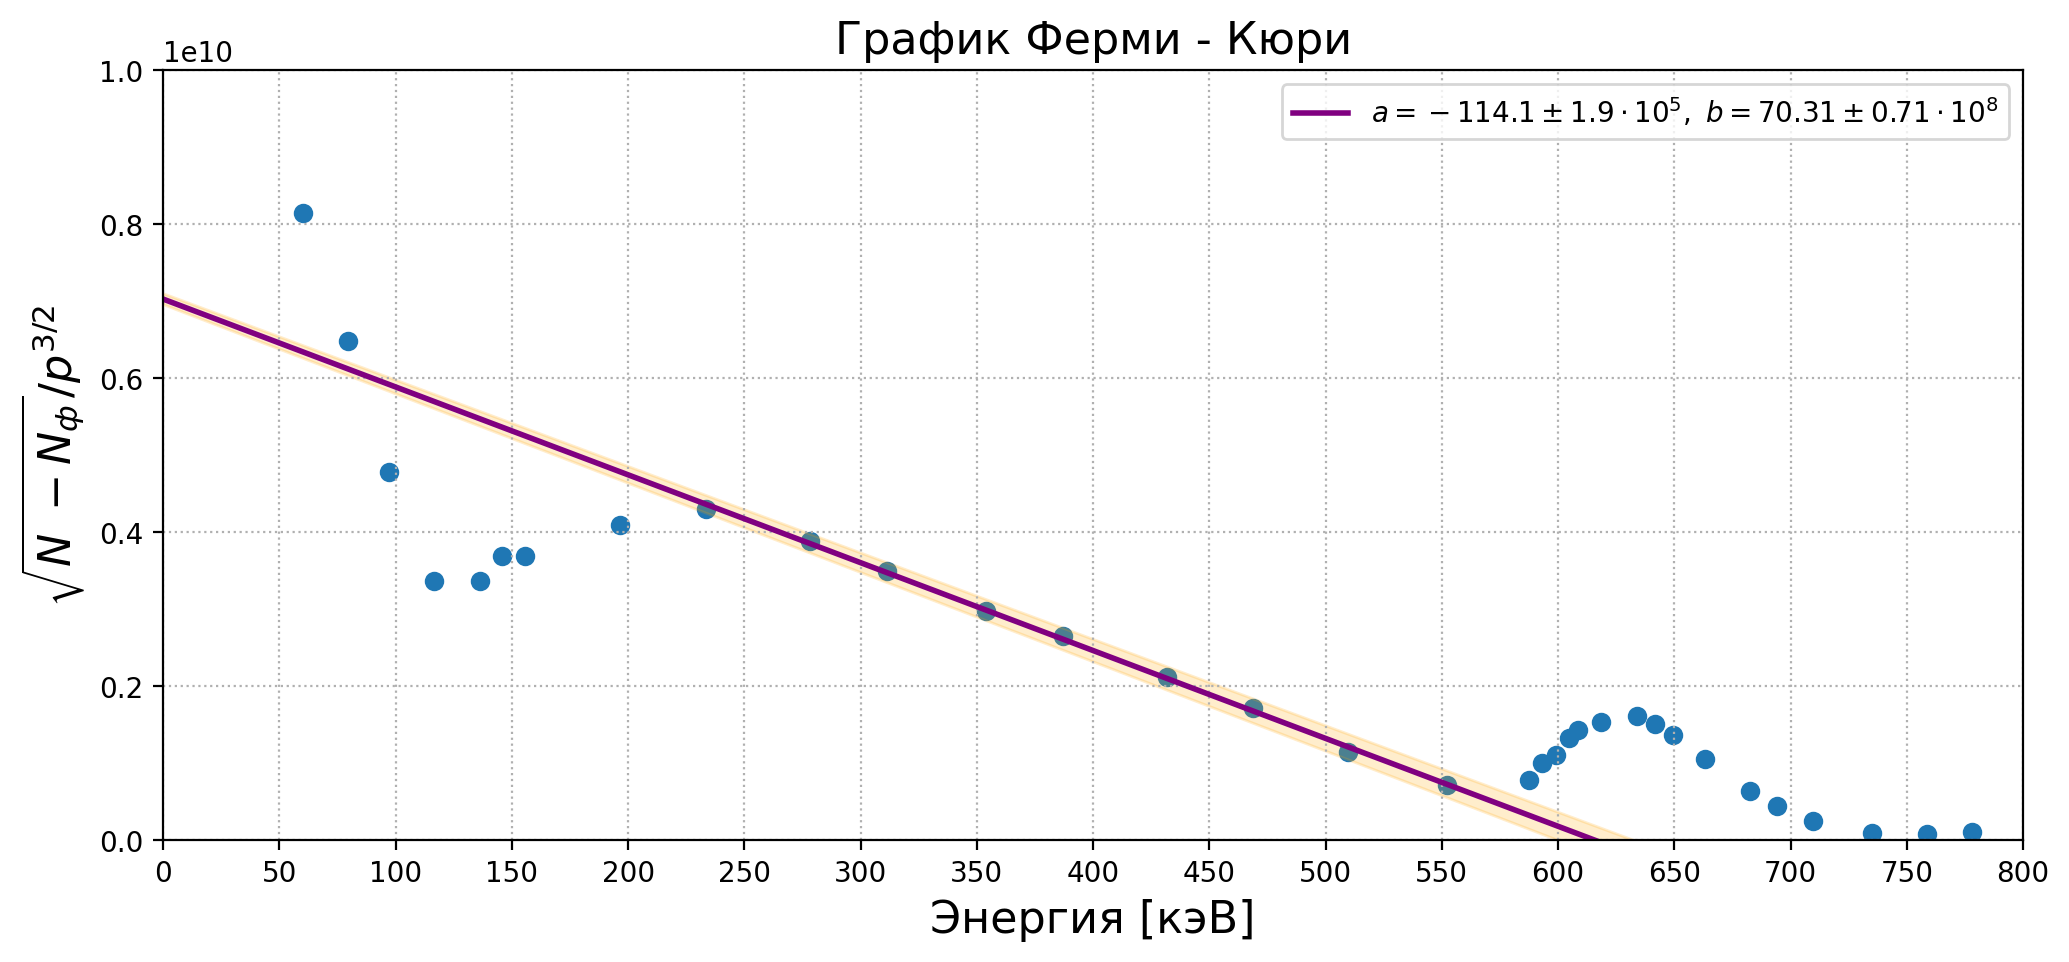

In [153]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(energy, fermi)
plt.plot(x_line, 
         MNK.slope * x_line + MNK.intercept, 
         color = 'purple', 
         label = f'$a = {MNK.slope / 1e5:.1f} \pm {MNK.stderr / 1e5:.1f} \cdot 10^5, \ b = {MNK.intercept / 1e8 :.2f} \pm {MNK.intercept_stderr / 1e8 :.2f} \cdot 10^8$',
         linewidth = 2)
plt.fill_between(x_line, (MNK.slope - MNK.stderr) * x_line + MNK.intercept - MNK.intercept_stderr, (MNK.slope + MNK.stderr) * x_line + MNK.intercept + MNK.intercept_stderr, alpha = 0.2, color = 'orange')
plt.xlabel("Энергия [кэВ]", fontsize = 16)
plt.ylabel(r"$\sqrt{N \ - N_{ф}} / p^{3/2}$", fontsize = 16)
plt.grid(ls = ':')
plt.xticks(np.arange(0, 1100, 50))
plt.xlim(0, 800)
plt.ylim(0, 1e10)
plt.legend();
plt.title("График Ферми - Кюри", fontsize = 16)